## Регуляризация для логистической регрессии

Для примера рассмотрим данные об результатах тестирования чипов и задачу их классификации на нормальные и бракованные.

In [4]:
%pylab inline

import pandas as pd

microchip = pd.read_csv(
    'microchip_test.csv',
    names=['Test1', 'Test2', 'Passed'],
)

X = microchip[['Test1', 'Test2']].values
y = microchip['Passed'].values

Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'Test2')

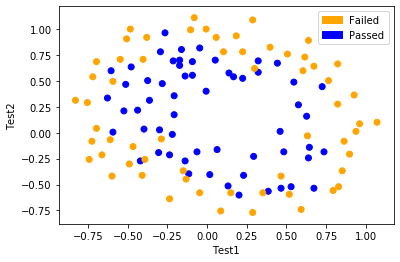

In [2]:
import seaborn as sns
import matplotlib.patches as mpatches

colors = microchip['Passed'].map({0: 'orange', 1: 'b'})
plt.scatter(x=microchip['Test1'], y=microchip['Test2'], c=colors)
red_patch = mpatches.Patch(color='orange', label='Failed')
blue_patch = mpatches.Patch(color='blue', label='Passed')
plt.legend(handles=[red_patch, blue_patch])
plt.xlabel('Test1')
plt.ylabel('Test2')

## Обучим модель логистической регрессии с полиномиальными признаками

In [6]:
def plot_boundary(clf, X, y, grid_step=.01, poly_featurizer=None):
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))


    # to every point from [x_min, m_max]x[y_min, y_max]
    # we put in correspondence its own color
    Z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

Accuracy on training set: 0.627


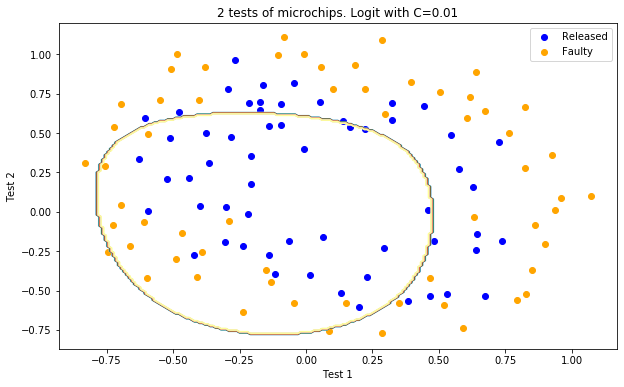

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

poly = PolynomialFeatures(degree=7)
X_poly = poly.fit_transform(X)

C = 1e-2

logreg = LogisticRegression(penalty='l2', C=C, random_state=17)
logreg.fit(X_poly, y)

plt.figure(figsize=(10,6))
plot_boundary(logreg, X, y, grid_step=.5, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Released')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='orange', label='Faulty')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title('2 tests of microchips. Logit with C=%s' % C)
plt.legend();

print("Accuracy on training set:", 
      round(logreg.score(X_poly, y), 3))

## Задание

Подобрать наилучшее значение коэффициента регуляризации C методом кросс-валидации.  
В качестве метрики будем использовать долю верных ответов (accuracy)

Accuracy on training set: 0.839


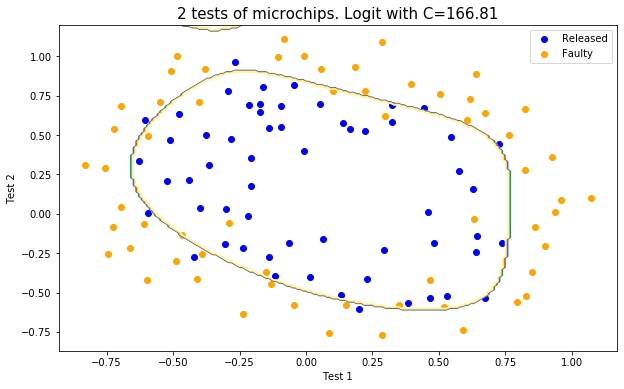

In [12]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

poly = PolynomialFeatures(degree=7)
X_poly = poly.fit_transform(X)

clf = LogisticRegressionCV(cv=5, penalty='l2', scoring='accuracy', random_state=0, max_iter=1000).fit(X_poly, y)

plt.figure(figsize=(10,6))
plot_boundary(clf, X, y, grid_step=.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Released')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='orange', label='Faulty')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
c = round(clf.C_[0], 3)
plt.title('2 tests of microchips. Logit with C=%s' % c, fontsize = 15)
plt.legend();
print("Accuracy on training set:", round(clf.score(X_poly, y), 3))    

In [6]:
clf.C_

array([166.81005372])

In [7]:
clf.Cs_

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

In [8]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

cv_scores = np.zeros((len(clf.Cs_), 5))
for i, c in enumerate(clf.Cs_):
    logreg = LogisticRegression(penalty='l2', C=c, random_state=0, max_iter = 1000)
    cv_score = cross_validate(logreg, X_poly, y, cv=5, scoring='neg_mean_squared_error')
    cv_scores[i, : ] = cv_score['test_score']

Text(0.5, 1.0, 'Cross validation')

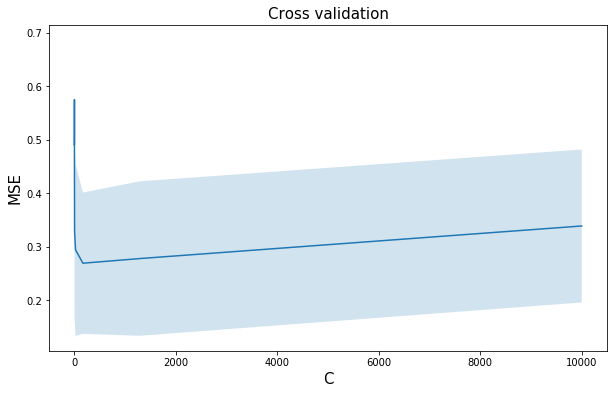

In [11]:
plt.figure(figsize=(10,6))
plt.plot(clf.Cs_, -cv_scores.mean(axis=1))
plt.fill_between(clf.Cs_,
                 -cv_scores.mean(axis=1) - cv_scores.std(axis=1),
                 -cv_scores.mean(axis=1) + cv_scores.std(axis=1),
                 alpha=0.2)
plt.xlabel('C', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.title('Cross validation', fontsize=15)

Text(0.5, 1.0, 'Cross validation')

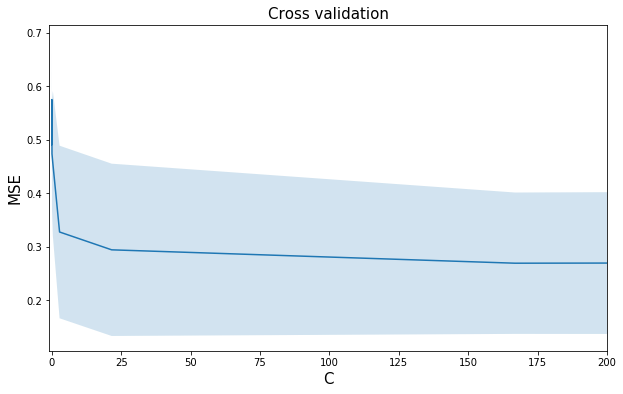

In [12]:
plt.figure(figsize=(10,6))
plt.plot(clf.Cs_, -cv_scores.mean(axis=1))
plt.fill_between(clf.Cs_,
                 -cv_scores.mean(axis=1) - cv_scores.std(axis=1),
                 -cv_scores.mean(axis=1) + cv_scores.std(axis=1),
                 alpha=0.2)
plt.xlim(-1, 200)
plt.xlabel('C', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.title('Cross validation', fontsize=15)

# Вывод
Таким образом, с помощью метода кросс-валидации установили, что наилучшее значение коэффициента регуляризации C = 166,81. По графику видим, что в этой точке наблюдается минимум (наименьшее значение MSE). Слева от этой точки функция убывает, что соответствует "недообученности" модели, справа - возрастает, что характеризует процесс "переобучения".